In [37]:
import numpy as np
import pandas as pd
import praw
import time
from pmaw import PushshiftAPI
import openai
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier


import nltk
from nltk.corpus import stopwords
from statistics import mean
from sklearn import metrics

In [7]:
df = pd.read_csv("./data/combined_data_for_use.csv", index_col=0)

In [8]:
df.sample(n=20)

,question,ai_answer,human_answer
4584,What have been the smartest decisions made in ...,\n\nSome of the smartest decisions made in hum...,Alexander Fleming not chucking out that petri-...
4424,I just turned down a high paying job for one w...,\n\nIt sounds like you might be crazy if you t...,"Sometimes, we just have to trust our intuition..."
2415,What actually makes new ADP or ATP?,\n\nNew ADP or ATP is produced when the body's...,"ATP/ADP have two major components, the ribose ..."
4350,$80/hr construction or go back to school?,\n\nThe answer to this question depends on wha...,"I would do it for a year or two, save up and i..."
2504,How can Doctors tell if one of your kidneys is...,\n\nThere is no specific way to tell if one of...,[deleted]
1835,Is having twins equally common all over the wo...,\n\nThere is no definitive answer to this ques...,"No, there are some places in the world where t..."
5502,Would Eastern Europe have been economically be...,\n\nThere is no definitive answer to this ques...,Yes - the disparity between East and West Germ...
1066,What do you think boosted your career the most?,\n\nThere is no definitive answer to this ques...,Soft skills can't be overstated. Interviews ar...
2396,Could venom antibodies be passed via breastfee...,\n\nThere is no definitive answer to this ques...,There's evidence that seroconversion is possib...
4180,Best way to stand out in a professional enviro...,\n\nThere is no one way to stand out in a prof...,Network and talk to people. You can learn a lo...


## EDA and pre-processing

In [9]:
#how many questions are questions?
count_q = 0
for t in df["question"]:
    if "?" in t:
        count_q +=1
print(count_q)
print(count_q/len(df))

4877
0.8830345826543545


In [10]:
#how many words on average are in the responses (ai vs human)
count_words = [len(nltk.word_tokenize(p)) for p in df["ai_answer"]]
mean(count_words)

45.58917255114974

In [11]:
mean(df['ai_answer'].str.len())

234.3706319029513

In [12]:
mean(df['human_answer'].str.len())

673.4162592793772

In [13]:
count_words = [len(nltk.word_tokenize(p)) for p in df["human_answer"]]
mean(count_words)

130.36212203512585

In [ ]:
# remove rows with 1 word responses: [deleted] , [removed]
# check and filter to only look at questions with question marks (ie 'actual' questions)

In [21]:
df_filtered = df[df["human_answer"] != "[deleted]"]
df_filtered = df[df["human_answer"] != "[removed]"]

In [19]:
df_filtered.loc[:,"question"]= [t if "?" in t else 0 for t in df_filtered.loc[:,"question"]]

/var/folders/r7/lck4_m6n3qvgvrpymc_hdq900000gn/T/ipykernel_73987/1237195794.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.loc[:,"question"]= [t if "?" in t else 0 for t in df_filtered.loc[:,"question"]]


In [28]:
df_filtered.loc[:,"is_human"] = [0 if i != "" else 1 for i in df_filtered.loc[:,"human_answer"]]

/var/folders/r7/lck4_m6n3qvgvrpymc_hdq900000gn/T/ipykernel_73987/2660490303.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.loc[:,"is_human"] = [0 if i != "" else 1 for i in df_filtered.loc[:,"human_answer"]]


In [25]:
df_filtered["is_ai"] = [1 if i != "" else 0 for i in df_filtered["ai_answer"]]

/var/folders/r7/lck4_m6n3qvgvrpymc_hdq900000gn/T/ipykernel_73987/743645387.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["is_ai"] = [1 if i != "" else 0 for i in df_filtered["ai_answer"]]


In [26]:
df_filtered["question_dubs"] = df_filtered["question"]

/var/folders/r7/lck4_m6n3qvgvrpymc_hdq900000gn/T/ipykernel_73987/2623476856.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["question_dubs"] = df_filtered["question"]


In [29]:
df_filtered.head()

,question,ai_answer,human_answer,is_ai,question_dubs,is_human
0,Redditors who make +$100K and aren’t being kil...,\n\nSome Redditors who make +$100K and aren’t ...,If that’s important to you then not working at...,1,Redditors who make +$100K and aren’t being kil...,0
1,Quitting after 8 years without notice. Am I wr...,"\n\nYes, you are wrong. You are allowed to qui...",You are not wrong.\nLoyalty is a two-way stree...,1,Quitting after 8 years without notice. Am I wr...,0
2,My boss is pressuring to tell him where my new...,\n\nIf you are in a position of authority and ...,No. Do not say anything to him. Managers are n...,1,My boss is pressuring to tell him where my new...,0
3,"BS’ed my way into a 160K job offer, am I crazy...",\n\nThere is no definitive answer to this ques...,Literally every single person I've known who e...,1,"BS’ed my way into a 160K job offer, am I crazy...",0
4,My boss confronted me about only working 7 hou...,\n\nIf your boss confronts you about working o...,Work an extra 15 minutes and tell him you didn...,1,My boss confronted me about only working 7 hou...,0


In [32]:
df_filtered = df_filtered[["question", "ai_answer","is_ai", "question_dubs", "human_answer", "is_human"]]

In [33]:
df_consolidated = df_filtered[['question', 'ai_answer', "is_ai"]].append(df_filtered[[
    'question_dubs','human_answer',"is_human"]].set_axis(['question', 'ai_answer',"is_ai"], axis=1)).reset_index(drop=True)

/var/folders/r7/lck4_m6n3qvgvrpymc_hdq900000gn/T/ipykernel_73987/1779882377.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_consolidated = df_filtered[['question', 'ai_answer', "is_ai"]].append(df_filtered[[


In [34]:
df_consolidated.rename(columns={"ai_answer": "answer", "is_ai": "is_human"}, inplace=True)

In [35]:
#remove phrases that would give away AI answer
df_consolidated.loc[df_consolidated["is_human"] == 1, "answer"] = df_consolidated["answer"].str.replace("I am only a machine", "")
df_consolidated.loc[df_consolidated["is_human"] == 1, "answer"] = df_consolidated["answer"].str.replace("As an AI language model", "")

In [41]:
df_consolidated.to_csv("final_dataset.csv")

## Modeling

In [74]:
df_consolidated.shape

(10754, 3)

In [43]:
X = df_consolidated["answer"]
y = df_consolidated["is_human"]

In [44]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42)

### Bernoulli

#### Count Vectorizer

In [45]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('bnb', BernoulliNB())
])

In [78]:
pipe_params = {
    'cvec__max_features' : [5000],
    'cvec__min_df' : [2,5],
    'cvec__max_df' : [0.9, 0.95],
    'cvec__ngram_range' : [(1,1), (1, 2), (2,2)],
    'cvec__stop_words' : ['english'],
}

In [79]:
gs = GridSearchCV(pipe, 
                  pipe_params, 
                  cv = 5)

In [80]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('bnb', BernoulliNB())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [5000], 'cvec__min_df': [2, 5],
                         'cvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'cvec__stop_words': ['english']})

In [81]:
gs.best_score_

0.7847489150650961

In [82]:
print(gs.score(X_train,y_train))
print(gs.score(X_test,y_test))


0.7970241785492871
0.7865377463741168


#### TFIDF

In [83]:
pipe_params_tvec = {
    'tvec__max_features' : [5000],
    'tvec__min_df' : [2,5],
    'tvec__max_df' : [0.9, 0.95],
    'tvec__ngram_range' : [(1,1), (1, 2), (2,2)],
    'tvec__stop_words' : ['english']
}

In [84]:
pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('bnb', BernoulliNB())
])

In [85]:
gs_tvec = GridSearchCV(pipe_tvec, 
                  pipe_params_tvec, 
                  cv = 5)

In [86]:
gs_tvec.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('bnb', BernoulliNB())]),
             param_grid={'tvec__max_df': [0.9, 0.95],
                         'tvec__max_features': [5000], 'tvec__min_df': [2, 5],
                         'tvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'tvec__stop_words': ['english']})

In [87]:
gs_tvec.best_score_

0.7847489150650961

In [88]:
print(gs_tvec.score(X_train,y_train))
print(gs_tvec.score(X_test,y_test))

0.7970241785492871
0.7865377463741168


### Multinomial

#### Count Vectorizer

In [89]:
pipe_mnb = Pipeline([
    ('cvec', CountVectorizer()),
    ('mnb', MultinomialNB())
])

In [90]:
pipe_params = {
    'cvec__max_features' : [5000],
    'cvec__min_df' : [2,5],
    'cvec__max_df' : [0.9, 0.95],
    'cvec__ngram_range' : [(1,1), (1, 2), (2,2)],
    'cvec__stop_words' : ['english'],
}

In [91]:
gs_mnb = GridSearchCV(pipe_mnb, 
                  pipe_params, 
                  cv = 5)

In [92]:
gs_mnb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('mnb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [5000], 'cvec__min_df': [2, 5],
                         'cvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'cvec__stop_words': ['english']})

In [93]:
gs_mnb.best_score_

0.7801611903285803

In [94]:
print(gs_mnb.score(X_train,y_train))
print(gs_mnb.score(X_test,y_test))


0.829882207067576
0.7831907772406099


#### TFIDF

In [95]:
pipe_params_tvec = {
    'tvec__max_features' : [5000],
    'tvec__min_df' : [2,5],
    'tvec__max_df' : [0.9, 0.95],
    'tvec__ngram_range' : [(1,1), (1, 2), (2,2)],
    'tvec__stop_words' : ['english']
}

In [96]:
pipe_tvec_mnb = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('mnb', MultinomialNB())
])

In [97]:
gs_tvec_mnb = GridSearchCV(pipe_tvec_mnb, 
                  pipe_params_tvec, 
                  cv = 5)

In [98]:
gs_tvec_mnb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('mnb', MultinomialNB())]),
             param_grid={'tvec__max_df': [0.9, 0.95],
                         'tvec__max_features': [5000], 'tvec__min_df': [2, 5],
                         'tvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'tvec__stop_words': ['english']})

In [99]:
gs_tvec_mnb.best_score_

0.8323620582765034

In [100]:
print(gs_tvec_mnb.score(X_train,y_train))
print(gs_tvec_mnb.score(X_test,y_test))

0.9030378177309362
0.8523614726664187


### Logistic Regression

#### Count Vectorizer

In [101]:
pipe_logr = Pipeline([
    ('cvec', CountVectorizer()),
    ('logr', LogisticRegressionCV(solver = 'liblinear'))
])

In [102]:
pipe_params = {
    'cvec__max_features' : [5000],
    'cvec__min_df' : [2,5],
    'cvec__max_df' : [0.9, 0.95],
    'cvec__ngram_range' : [(1,1), (1, 2), (2,2)],
    'cvec__stop_words' : ['english'],
}

In [103]:
gs_logr = GridSearchCV(pipe_logr, 
                  pipe_params, 
                  cv = 5)

In [104]:
gs_logr.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('logr',
                                        LogisticRegressionCV(solver='liblinear'))]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [5000], 'cvec__min_df': [2, 5],
                         'cvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'cvec__stop_words': ['english']})

In [105]:
print(gs_logr.score(X_train,y_train))
print(gs_logr.score(X_test,y_test))

0.9480471171729696
0.8847155076236519


In [106]:
gs_logr.best_score_

0.8773713577185369

#### TFIDF

In [107]:
pipe_tvec_logr = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('logr', LogisticRegressionCV(solver = 'liblinear'))
])

In [108]:
pipe_params_ = {
    'tvec__max_features' : [5000],
    'tvec__min_df' : [2,5],
    'tvec__max_df' : [0.9, 0.95],
    'tvec__ngram_range' : [(1,1), (1, 2), (2,2)],
    'tvec__stop_words' : ['english']
}

In [109]:
gs_tvec_logr = GridSearchCV(pipe_tvec_logr, 
                  pipe_params_, 
                  cv = 5)

In [110]:
gs_tvec_logr.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('logr',
                                        LogisticRegressionCV(solver='liblinear'))]),
             param_grid={'tvec__max_df': [0.9, 0.95],
                         'tvec__max_features': [5000], 'tvec__min_df': [2, 5],
                         'tvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'tvec__stop_words': ['english']})

In [111]:
print(gs_tvec_logr.score(X_train,y_train))
print(gs_tvec_logr.score(X_test,y_test))

0.9577185368877867
0.8921532168092228


In [112]:
gs_tvec_logr.best_score_

0.8787352758834469

### Decision Tree

In [113]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import export_text, DecisionTreeClassifier, plot_tree

In [114]:
cv = CountVectorizer(min_df=2)
cv.fit(X_train)

X_train_cv = cv.transform(X_train)
X_test_cv = cv.transform(X_test)

In [115]:
tv = TfidfVectorizer(min_df=2)
tv.fit(X_train)

X_train_tv = tv.transform(X_train)
X_test_tv = tv.transform(X_test)

In [116]:
dtc = DecisionTreeClassifier()

In [117]:
dt = dtc.fit(X_train_cv, y_train)

In [118]:
print(dt.score(X_train_cv, y_train))
print(dt.score(X_test_cv, y_test))

0.9997520148791073
0.8300483451097063


In [145]:
dt_tvec = dtc.fit(X_train_tv, y_train)

In [146]:
print(dt.score(X_train_tv, y_train))
print(dt.score(X_test_tv, y_test))

0.9997520148791073
0.8259576050576423


### Random Forest

#### Count Vectorizer

In [119]:
rf = RandomForestClassifier()

In [120]:
rf_params = {
    'n_estimators' : [100, 150, 200],
    'max_depth': [None, 3, 4, 5, 6, 7]
}
gs_dt = GridSearchCV(rf, param_grid=rf_params, cv=5, n_jobs=-1)
gs_dt.fit(X_train_cv, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 3, 4, 5, 6, 7],
                         'n_estimators': [100, 150, 200]})

In [121]:
print(gs_dt.best_score_)
print(gs_dt.best_params_)

0.8989460632362059
{'max_depth': None, 'n_estimators': 200}


In [122]:
gs_dt.best_estimator_

RandomForestClassifier(n_estimators=200)

In [123]:
gs_dt.score(X_test_cv, y_test)

0.9036816660468575

In [124]:
gs_dt.score(X_train_cv, y_train)

0.9997520148791073

#### TFIDF

In [125]:
rf_params = {
    'n_estimators' : [100, 150, 200],
    'max_depth': [None, 3, 4, 5, 6, 7]
}
gs_dt_tvec = GridSearchCV(rf, param_grid=rf_params, cv=5, n_jobs=-1)
gs_dt_tvec.fit(X_train_tv, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 3, 4, 5, 6, 7],
                         'n_estimators': [100, 150, 200]})

In [126]:
print(gs_dt_tvec.best_score_)
print(gs_dt_tvec.best_params_)

0.9001859888406696
{'max_depth': None, 'n_estimators': 200}


In [127]:
gs_dt_tvec.best_estimator_

RandomForestClassifier(n_estimators=200)

In [128]:
gs_dt_tvec.score(X_test_tv, y_test)

0.9100037188545927

In [129]:
gs_dt_tvec.score(X_train_tv, y_train)

0.9997520148791073

### ADA Boost

#### Count Vectorizer + Logistic Regression

In [130]:
abc = AdaBoostClassifier(random_state = 42)

In [131]:
dt_abc = abc.fit(X_train_cv, y_train)

In [132]:
print(dt_abc.score(X_train_cv, y_train))
print(dt_abc.score(X_test_cv, y_test))

0.8530688158710478
0.837486054295277


In [133]:
abc = AdaBoostClassifier(random_state = 42, n_estimators=100)
dt_abc = abc.fit(X_train_cv, y_train)
print(dt_abc.score(X_train_cv, y_train))
print(dt_abc.score(X_test_cv, y_test))

0.8825790452572846
0.8568240981777613


In [134]:
abc = AdaBoostClassifier(random_state = 42, n_estimators=1000)
dt_abc = abc.fit(X_train_cv, y_train)
print(dt_abc.score(X_train_cv, y_train))
print(dt_abc.score(X_test_cv, y_test))

0.9864848109113453
0.8910375604313872


In [135]:
abc_logreg = AdaBoostClassifier(random_state = 42, n_estimators=1000, estimator=LogisticRegression())
abc_logreg.fit(X_train_cv, y_train)

abc_logreg.score(X_test_cv, y_test)

0.9025660096690219

In [136]:
abc_logreg.score(X_train_cv, y_train)

0.9724736515809052

#### TFIDF + Logistic Regression

In [137]:
abc = AdaBoostClassifier(random_state = 42)

In [138]:
dt_abc_tv = abc.fit(X_train_tv, y_train)

In [139]:
print(dt_abc_tv.score(X_train_tv, y_train))
print(dt_abc_tv.score(X_test_tv, y_test))

0.8637321760694359
0.8378579397545556


In [140]:
abc = AdaBoostClassifier(random_state = 42, n_estimators=100)
dt_abc_tv = abc.fit(X_train_tv, y_train)
print(dt_abc_tv.score(X_train_tv, y_train))
print(dt_abc_tv.score(X_test_tv, y_test))

0.8891506509609424
0.8571959836370397


In [141]:
abc = AdaBoostClassifier(random_state = 42, n_estimators=1000)
dt_abc_tv = abc.fit(X_train_tv, y_train)
print(dt_abc_tv.score(X_train_tv, y_train))
print(dt_abc_tv.score(X_test_tv, y_test))

0.9993800371977681
0.8977314986984009


In [142]:
abc_logreg_tv = AdaBoostClassifier(random_state = 42, n_estimators=1000, estimator=LogisticRegression())
abc_logreg_tv.fit(X_train_tv, y_train)

abc_logreg_tv.score(X_test_tv, y_test)

0.8609148382298252

In [143]:
abc_logreg_tv.score(X_train_tv, y_train)

0.8763794172349659

### Evaluating the Model

In [147]:
# Get predictions
preds = abc_logreg.predict(X_test_cv)

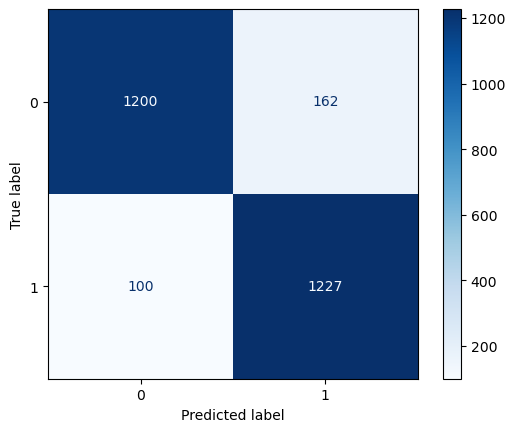

In [148]:

# View confusion matrix
ConfusionMatrixDisplay.from_estimator(abc_logreg, X_test_cv, y_test, cmap='Blues', values_format='d');

In [150]:
def find_cm(preds):
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    
    print(f"TN: {tn}\nFP: {fp}\nFN: {fn}\nTP: {tp}")
    
    print(f"Sensitivity: {tp/(tp+fn)}\nSpecificity: {tn/(tn + fp)}")
    
    print(f"\nAccuracy: {(tp+tn)/(tp+fn+fp+tn)}")
    
    #return tn, fp, fn, tp

find_cm(preds)

TN: 1200
FP: 162
FN: 100
TP: 1227
Sensitivity: 0.9246420497362472
Specificity: 0.8810572687224669

Accuracy: 0.9025660096690219
